In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d asaniczka/mammals-image-classification-dataset-45-animals

 99% 183M/185M [00:07<00:00, 29.9MB/s]
100% 185M/185M [00:07<00:00, 27.3MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mammals-image-classification-dataset-45-animals.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import os
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
import matplotlib.pyplot as plt


In [8]:
# Correct path to the main directory
main_dir = '/content/mammals'

# Creating train, validation, and test directories
base_dir = '/content/mammals_split'
for dir in ['train', 'validation', 'test']:
    if not os.path.exists(os.path.join(base_dir, dir)):
        os.makedirs(os.path.join(base_dir, dir))

# Splitting data into train, validation, and test sets
for species in os.listdir(main_dir):
    species_dir = os.path.join(main_dir, species)
    images = os.listdir(species_dir)
    np.random.shuffle(images)
    train_split = int(0.7 * len(images))
    val_split = int(0.85 * len(images))

    for i, img in enumerate(images):
        if i < train_split:
            dest_dir = os.path.join(base_dir, 'train', species)
        elif i < val_split:
            dest_dir = os.path.join(base_dir, 'validation', species)
        else:
            dest_dir = os.path.join(base_dir, 'test', species)

        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)

        shutil.copy(os.path.join(species_dir, img), os.path.join(dest_dir, img))

# Set up ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'),
                                                    target_size=(256, 256), batch_size=32,
                                                    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(os.path.join(base_dir, 'validation'),
                                                         target_size=(256, 256), batch_size=32,
                                                         class_mode='categorical')

test_generator = test_datagen.flow_from_directory(os.path.join(base_dir, 'test'),
                                                  target_size=(256, 256), batch_size=32,
                                                  class_mode='categorical')


Found 9602 images belonging to 45 classes.
Found 2064 images belonging to 45 classes.
Found 2085 images belonging to 45 classes.


In [9]:
# Building a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(45, activation='softmax'))  # 45 classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, steps_per_epoch=100, epochs=15,
                    validation_data=validation_generator, validation_steps=50)


Epoch 1/15
100/100 [==============================] - 70s 632ms/step - loss: 5.3353 - accuracy: 0.0494 - val_loss: 3.5886 - val_accuracy: 0.0913
Epoch 2/15
100/100 [==============================] - 60s 597ms/step - loss: 3.5645 - accuracy: 0.0878 - val_loss: 3.4258 - val_accuracy: 0.1163
Epoch 3/15
100/100 [==============================] - 59s 594ms/step - loss: 3.4887 - accuracy: 0.1019 - val_loss: 3.5106 - val_accuracy: 0.1112
Epoch 4/15
100/100 [==============================] - 57s 574ms/step - loss: 3.4152 - accuracy: 0.1172 - val_loss: 3.2440 - val_accuracy: 0.1506
Epoch 5/15
100/100 [==============================] - 59s 594ms/step - loss: 3.3293 - accuracy: 0.1319 - val_loss: 3.1144 - val_accuracy: 0.1800
Epoch 6/15
100/100 [==============================] - 59s 591ms/step - loss: 3.2864 - accuracy: 0.1406 - val_loss: 3.1099 - val_accuracy: 0.1825
Epoch 7/15
100/100 [==============================] - 66s 666ms/step - loss: 3.1781 - accuracy: 0.1631 - val_loss: 3.0989 - val_ac

In [10]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy*100:.2f}%')


65/65 [==============================] - 4s 64ms/step - loss: 2.7931 - accuracy: 0.2519
Validation accuracy: 25.19%


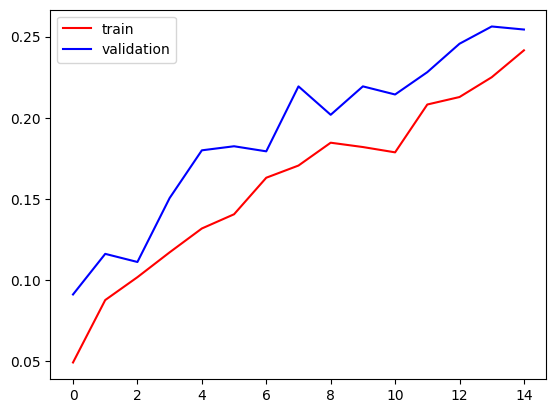

In [11]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [1]:
model.save('cnn_model.h5')

NameError: ignored

In [ ]:
# Model Building: VGG16 with Transfer Learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base_model
base_model.trainable = False

# Create the model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(45, activation='softmax'))  # 45 classes

# Compile the model
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[early_stopping, checkpoint])


Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 4.4843 - accuracy: 0.0272

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 81s 710ms/step - loss: 4.4843 - accuracy: 0.0272 - val_loss: 3.8048 - val_accuracy: 0.0237
Epoch 2/30
100/100 [==============================] - 67s 667ms/step - loss: 3.8038 - accuracy: 0.0241 - val_loss: 3.7736 - val_accuracy: 0.0525
Epoch 3/30
100/100 [==============================] - 65s 653ms/step - loss: 3.7772 - accuracy: 0.0347 - val_loss: 3.7176 - val_accuracy: 0.0419
Epoch 4/30
100/100 [==============================] - 66s 660ms/step - loss: 3.7536 - accuracy: 0.0379 - val_loss: 3.7525 - val_accuracy: 0.0450
Epoch 5/30
100/100 [==============================] - 67s 672ms/step - loss: 3.7525 - accuracy: 0.0331 - val_loss: 3.6949 - val_accuracy: 0.0500
Epoch 6/30
100/100 [==============================] - 70s 704ms/step - loss: 3.7472 - accuracy: 0.0391 - val_loss: 3.6694 - val_accuracy: 0.0406
Epoch 7/30
100/100 [==============================] - 67s 670ms/step - loss: 3.7307 - accuracy: 0.0397 - val_loss: 3.6810 - val_accuracy: 0.0